### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

Done


### Get data

In [31]:
BIN_SIZE = 0.03
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    # df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values
    df['session'] = df.monkey[0]+':'+df.date[0]
    
    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 2)
        print('Neurons (all, left):', df[signal].values[0].shape[1], df_[signal].values[0].shape[1])
    
    #combine pmd and m1
    MCx_signals = [signal for signal in time_signals if 'M1' in signal or 'PMd' in signal]
    if len(MCx_signals) > 1:
        df_ = pyal.merge_signals(df_, MCx_signals, 'MCx_spikes')
    elif len(MCx_signals) == 1:
        df_ = pyal.rename_fields(df_, {MCx_signals[0]:'MCx_spikes'})
    time_signals = [signal for signal in pyal.get_time_varying_fields(df_) if 'spikes' in signal]

    #select trials
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    #get rates
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    return df_



In [52]:
datadir = pathlib.Path("/home/jcc319/data/random_walk")
# datadir = pathlib.Path("/home/jcc319/multi_animal_alignment/data")
_AllAnimalList = ['Chewie', 'Mihili', "MrT"]

_AllAnimalFiles=[]
for animal in _AllAnimalList:
    _AllAnimalFiles.extend(utility.find_file(datadir / animal, 'mat'))
# print(_AllAnimalFiles)

In [53]:
file = _AllAnimalFiles[11]
# for file in _AllAnimalFiles:
print(file)
raw_df = pyal.mat2dataframe(file, shift_idx_fields=True)
df = prep_general(raw_df)
print('Trials (all, left):', len(raw_df), len(df))
df = pyal.restrict_to_interval(df, start_point_name = 'idx_trial_start', end_point_name = 'idx_trial_end')


#fix target and position locations
df['target_center'] = [np.reshape(x.T.flatten(), x.shape, order = 'C') for x in df['target_center']]
mean_pos = np.mean(np.vstack(df.pos), axis = 0)
# df['pos'] = [x - mean_pos for x in df['pos']] 

df[['idx_go_cue1',
    'idx_go_cue2',
    'idx_go_cue3',
    'idx_go_cue4']] = pd.DataFrame(df.idx_go_cue.tolist(), index= df.index)

/home/jcc319/data/random_walk/Chewie/Chewie_RT_VR_2013-10-09.mat
Neurons (all, left): 74 45
Trials (all, left): 423 133


/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


### Check rates

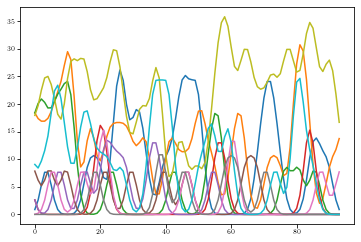

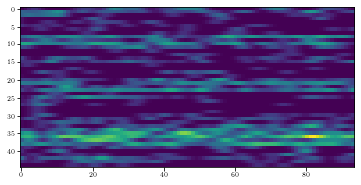

In [54]:
%matplotlib inline
rates = df.MCx_rates.values[0]
# print(df_reaches.columns)
plt.figure()
for i in range(10):
    plt.plot(rates[:,i])
    
fig, ax = plt.subplots()
ax.imshow(rates.T)


In [35]:
# %matplotlib widget
# # %matplotlib inline

# cmap = plt.get_cmap('viridis')
# norm = plt.Normalize(-np.pi, np.pi)

# #subset reaches that start around the center
# ntrials = 50
# plt.figure()
# exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
#                                      rel_start=int(-0.05/BIN_SIZE),
#                                      rel_end=int(0.4/BIN_SIZE)
#                                     )

# df = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
# for i in range(ntrials):
#     pos = df.pos.values[i]
#     # targets = df_.target_center.values[i]
#     angle = df.target_direction.values[i]
#     plt.plot(*pos[:].T, c=cmap(norm(angle)))
#     # plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
# plt.gca().set_aspect(1)

# # %matplotlib inline
# #check dimensionality
# model = pyal.fit_dim_reduce_model(df, PCA(), 'MCx_rates')
# dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
# print(dim)

# plt.figure()
# plt.plot(np.cumsum(model.explained_variance_ratio_))
# plt.xlim([0,20])

# # plot PCA
# df["target_id"] = df.apply(monkey_defs.get_target_id, axis=1)  # add a field `target_id` with int values
# colors = utility.get_colors(8)
# fig = plt.figure(figsize = (6,6))
# ax = fig.add_subplot(projection = '3d')

# rates = np.concatenate(df['M1_rates'].values, axis=0)
# rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
# df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
# for tar in range(monkey_defs.n_targets):
#     df__ = pyal.select_trials(df_, df_.target_id==tar)
#     ex = pyal.get_sig_by_trial(df__,'_pca')
#     ex = np.mean(ex, axis=2)[:,:3]
#     ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=3)
#     # ax.view_init(60,-47)

# # for i in range(50):
# #     pca = df_._pca.values[i]
# #     tar = df_.target_id.values[i]
# #     ax.plot(pca[:,0],pca[:,1],pca[:,2],c=colors[tar], alpha=0.5)
# df_.head()

### separate into reaches

In [55]:
n_target_groups = 8
df_reaches = pd.DataFrame()
#separate by reaches
for i in range(4):
    start_point_name = 'idx_go_cue' +str(i+1)
    end_point_name = ('idx_go_cue' + str(i+2)) if i < 3 else 'idx_trial_end'
    df_ = pyal.restrict_to_interval(df, start_point_name, end_point_name)
    if i>0:
        df_['start_center'] = [x[i-1] for x in df_['target_center']] #assume reach starts in target of prev reach
    df_['target_center'] = [x[i] for x in df_['target_center']]
    df_['reach'] = i+1
    df_['idx_go_cue']= df_[start_point_name]
    df_['idx_reach_end'] = df_[end_point_name] - df_[start_point_name] 
    df_reaches = pd.concat([df_reaches, df_])
df_reaches = df_reaches.sort_values(by=['trial_id', 'reach'])
df_reaches = df_reaches[df_reaches.idx_reach_end < 200] #TODO: better cutoff for slow reaches

#fix pos offset
df_second_reaches = df_reaches[df_reaches.reach == 2] #look at offset for second reach
mean_offset = np.mean([pos[0] - start_center for start_center,pos in zip(df_second_reaches.start_center, df_second_reaches.pos)],axis = 0) 
df_reaches['pos'] = [x - mean_offset for x in df_reaches['pos']] 

#center targets and pos at origin
df_reaches['dist_start_center'] = [np.linalg.norm(x[0]) for x in df_reaches.pos]
df_reaches['pos_centered'] = [x - x[0] for x in df_reaches.pos]
df_reaches['target_centered'] = [y - x[0] for x,y in zip(df_reaches.pos,df_reaches.target_center)]

#get target angle and group
df_reaches['target_angle'] = [math.degrees(math.atan2(x[1],x[0])) for x in df_reaches.target_centered]
df_reaches['target_angle'] = [360+x if x < 0 else x for x in df_reaches.target_angle]
df_reaches['target_group'] = [math.floor(x/(360/n_target_groups)) for x in df_reaches.target_angle]

#look at exec_epoch only
df_reaches = pyal.add_movement_onset(df_reaches)
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(0.0/BIN_SIZE),
                                     rel_end=int(0.35/BIN_SIZE)
                                    )
df_reaches_move = pyal.restrict_to_interval(df_reaches, epoch_fun=exec_epoch)
df_reaches_move.reset_index()

print('Trials (total, movement):', len(df_reaches), len(df_reaches_move))
df_reaches.head()


Trials (total, movement): 526 489


/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/movement_onset_and_peak.py:82: UserWarning: Could not identify movement onset
  warnings.warn("Could not identify movement onset")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/movement_onset_and_peak.py:82: UserWarning: Could not identify movement onset
  warnings.warn("Could not identify movement onset")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/movement_onset_and_peak.py:82: UserWarning: Could not identify movement onset
  warnings.warn("Could not identify movement onset")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/movement_onset_and_peak.py:82: UserWarning: Could not identify movement onset
  warnings.warn("Could not identify movement onset")
/tmp/ipykernel_12747/2955233032.py:39: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  3   6   7  21  25  29  40  46  46  47

,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,reach,idx_reach_end,start_center,dist_start_center,pos_centered,target_centered,target_angle,target_group,vel_norm,idx_movement_on
0,Chewie,10-09-2013,RT,"[-3.231192111968994, 8.401151657104492]",3,R,0.03,VR,0.52,BL,...,1,30,NaN,0.675684,"[[0.0, 0.0], [0.10028067132193774, -0.09407917...","[-3.8983933952418126, 8.294421942312688]",115.173610,2,"[4.697081346412698, 4.477266575103811, 4.01261...",10.0
0,Chewie,10-09-2013,RT,"[-0.7502593398094177, 1.636946201324463]",3,R,0.03,VR,0.52,BL,...,2,22,"[-3.231192111968994, 8.401151657104492]",8.290681,"[[0.0, 0.0], [0.03385607797002743, 0.088396976...","[1.8613732607009856, -6.231647902065042]",286.630717,6,"[2.8362906817714704, 3.2014790847796615, 2.214...",6.0
0,Chewie,10-09-2013,RT,"[0.3820771276950836, -4.594175815582275]",3,R,0.03,VR,0.52,BL,...,3,22,"[-0.7502593398094177, 1.636946201324463]",1.515858,"[[0.0, 0.0], [0.018927500645665507, 0.06379828...","[1.1179041415521813, -5.919462100011792]",280.694488,6,"[1.6623865625370762, 2.5723137642258496, 2.133...",6.0
0,Chewie,10-09-2013,RT,"[-0.8422622680664062, 0.48215451836586]",3,R,0.03,VR,0.52,BL,...,4,16,"[0.3820771276950836, -4.594175815582275]",4.861753,"[[0.0, 0.0], [0.015806595284785452, -0.1564203...","[-1.3284874028135567, 5.3195326822777815]",104.022093,2,"[6.0043351031402965, 4.510165953142295, 3.5231...",6.0
1,Chewie,10-09-2013,RT,"[0.13310198485851288, -4.421789169311523]",4,R,0.03,VR,0.52,BL,...,1,127,NaN,1.187728,"[[0.0, 0.0], [0.04269493370125499, -0.01907101...","[0.2272451500787458, -3.237798430777943]",274.014726,6,"[1.9036413342241123, 1.2593440314674533, 0.645...",65.0


### look at reaches

Trials (total, movement): 526 489


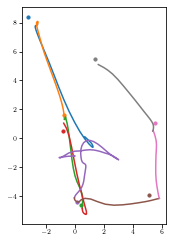

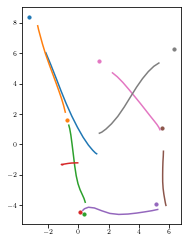

In [56]:
%matplotlib inline
# sequential reaches
# #all starting locations
# plt.figure()
# for pos,targets in zip(df_reaches.pos[:], df_reaches.target_center[:]):
#     plt.scatter(*pos[0].T)
#     # plt.scatter(*targets[:].T, s = 10)
# plt.gca().set_aspect(1)

ntrials = 8
plt.figure()
for pos,targets in zip(df_reaches.pos[:ntrials], df_reaches.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

plt.figure()
for pos,targets in zip(df_reaches_move.pos[:ntrials], df_reaches_move.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

In [57]:
# df_reaches.columns
# print(np.array(df_reaches.idx_reach_end - df_reaches.idx_movement_on))
# plt.figure()
# plt.hist(df_reaches.idx_reach_end - df_reaches.idx_movement_on)
# plt.figure()
# plt.hist(df_reaches.idx_movement_on)
# df_reaches_move.head()

#### plot positions

Trials (subset, subset_movement): 83 76


(-10.0, 10.0)

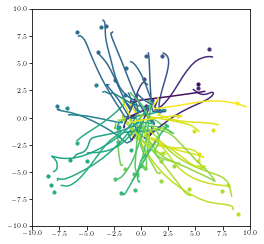

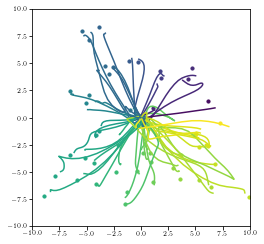

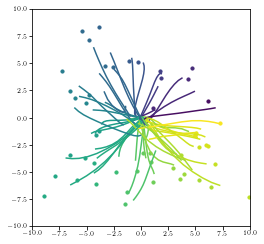

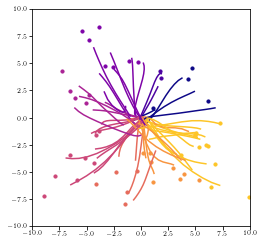

In [58]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)

#subset reaches that start around the center
ntrials = 50
plt.figure()
df_center = df_reaches[df_reaches.dist_start_center <2.5]
for i in range(ntrials):
    pos = df_center.pos.values[i]
    targets = df_center.target_center.values[i]
    angle = df_center.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])


#subset reaches that start around the center, centered reaches
plt.figure()
for i in range(ntrials):
    pos = df_center.pos_centered.values[i]
    targets = df_center.target_centered.values[i]
    angle = df_center.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches, movement only
df_center_move = df_reaches_move[df_reaches_move.dist_start_center <2.5]
plt.figure()
for i in range(ntrials):
    pos = df_center_move.pos_centered.values[i]
    targets = df_center_move.target_centered.values[i]
    angle = df_center_move.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

print('Trials (subset, subset_movement):', len(df_center), len(df_center_move))

#subset reaches that start around the center, centered reaches, movement only, grouped
colors = utility.get_colors(n_target_groups)
df_center_move = df_reaches_move[df_reaches_move.dist_start_center <2.5]
plt.figure()
for i in range(ntrials):
    pos = df_center_move.pos_centered.values[i]
    targets = df_center_move.target_centered.values[i]
    target_group = df_center_move.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

21


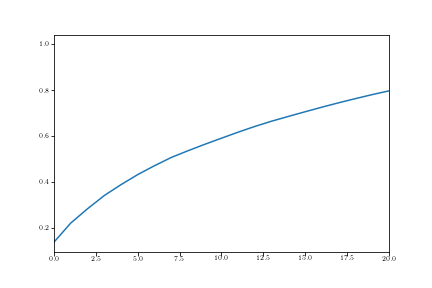

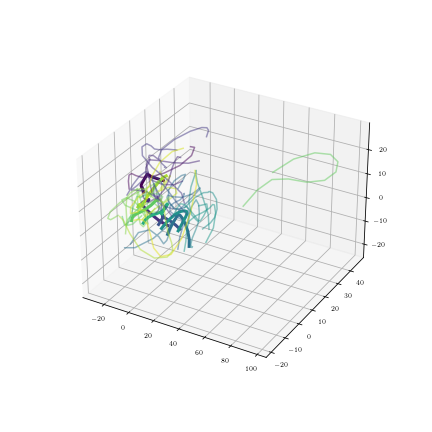

In [59]:
%matplotlib widget
# %matplotlib inline
df_ = df_reaches_move

#check dimensionality
model = pyal.fit_dim_reduce_model(df_, PCA(), 'MCx_rates')
dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
print(dim)

plt.figure()
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlim([0,20])

# plot PCA
colors = utility.get_colors(8, 'viridis')
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection = '3d')

rates = np.concatenate(df['MCx_rates'].values, axis=0)
rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
df_ = pyal.apply_dim_reduce_model(df_, rates_model, 'MCx_rates', '_pca');
for tar in range(n_target_groups):
    df__ = pyal.select_trials(df_, df_.target_group==tar)
    ex = pyal.get_sig_by_trial(df__,'_pca')
    ex = np.mean(ex, axis=2)[:,:3]
    ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=3)
    # ax.view_init(60,-47)

# for i in range(len(df_)):
for i in range(30):
    pca = df_._pca.values[i]
    angle = df_.target_angle.values[i]
    ax.plot(pca[:,0],pca[:,1],pca[:,2],c=cmap(norm(angle)), alpha=0.5)


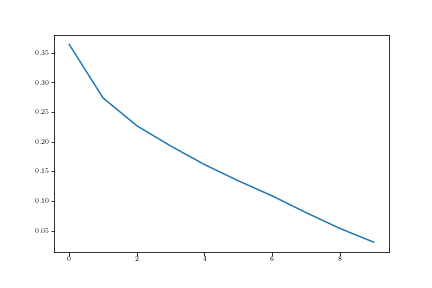

In [70]:
#cca
#upper bound
n_shared_trial1 = len(df_)
trialList1 = np.arange(n_shared_trial1)

r = []
for n in range(params.n_iter * 10):
    params.rng.shuffle(trialList1)
    # non-overlapping randomised trials
    trial1 = trialList1[:n_shared_trial1//2]
    trial2 = trialList1[-(n_shared_trial1//2):]
    data1 = np.concatenate(df_.iloc[trial1]._pca.values, axis = 0)
    data2 = np.concatenate(df_.iloc[trial2]._pca.values, axis = 0)
    r.append(dt.canoncorr(data1, data2))
CCsU = np.array(r)
CCsU.shape
CCsU = np.percentile(CCsU, 99, axis=0).T
CCsU
plt.figure()
plt.plot(CCsU)

19


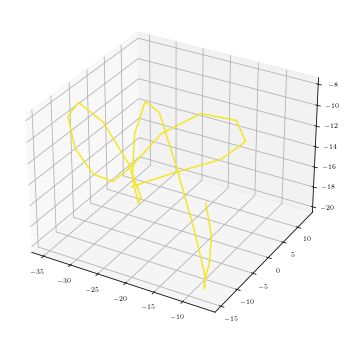

In [63]:
# %matplotlib widget
df_ = df_reaches
df_ = df_reaches[df_reaches.dist_start_center <2.5]
%matplotlib inline
#check dimensionality
model = pyal.fit_dim_reduce_model(df_, PCA(), 'MCx_rates')
dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
print(dim)

# perform PCA
df_ = pyal.dim_reduce(df_,PCA(20), 'MCx_rates', 'MCx_pca')

# plot PCA
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection = '3d')
for i in range(1):
    pca = df_.MCx_pca.values[i]
    angle = df_.target_angle.values[i]
    ax.plot(pca[:,0],pca[:,1],pca[:,2],c=cmap(norm(angle)))


In [125]:
pca.shape

(28, 20)

In [128]:
# np.concatenate(df_.MCx_rates).shape
df_.MCx_rates.values[0].shape

(90, 65)

(array([  4.,  11., 139., 280., 125.,  44.,   6.,   2.,   3.,   1.]),
 array([ 20. ,  35.5,  51. ,  66.5,  82. ,  97.5, 113. , 128.5, 144. ,
        159.5, 175. ]),
 <BarContainer object of 10 artists>)

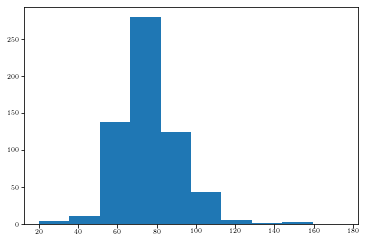

In [168]:
plt.hist(df_.idx_reach_end)